# Barren Plateaus問題

Barren Plateau問題とは、  
量子ニューラルネットワークにおいてパラメータがランダムに初期化された場合、  
量子ビットや量子回路の深さの増加に伴い勾配が消失して学習が停滞してしまう現象のこと。

本notebookではランダムに初期化されたパラメータを持つ量子ニューラルネットワークにおいて、  
量子ビット数の増加に伴って勾配が消失することをシミュレータ上で検証する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, PauliSumOp, Gradient

# ランダム回路の生成


例としてパラメータ1つの量子回路で、そのほかはランダムに初期化されている回転ゲートを含む回路を実装する。

In [2]:
def generate_random_qnn(qubits, symbol, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    circuit = QuantumCircuit(qubits)
    for qubit in range(qubits):
        circuit.ry(np.pi / 4.0, qubit)

    for d in range(depth):
        # Add a series of single qubit rotations.
        for qubit in range(qubits):
            random_n = np.random.uniform()
            random_rot = np.random.uniform() * 2.0 * np.pi if qubit != 0 or d != 0 else symbol
            circuit.rz(random_rot, qubit)
            if random_n > 2. / 3.:
                # Add a Z.
                circuit.rz(random_rot, qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit.ry(random_rot, qubit)
            else:
                # Add a X.
                circuit.rx(random_rot, qubit)

        # Add CZ ladder.
        for src, dest in zip(range(qubits), range(qubits)[1:]):
            circuit.cz(src, dest)

    return circuit

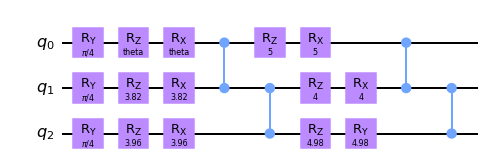

In [3]:
# 生成される回路の確認(例:3量子ビット)
qc_test = generate_random_qnn(3, Parameter('theta'), 2)
qc_test.draw('mpl')

In [4]:
# 勾配の計算
def calc_gradient(qc, hamiltonian, params):
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
    state_grad = Gradient().convert(expectation)
    value_dict = dict(zip(qc.parameters, params))
    result = state_grad.assign_parameters(value_dict).eval()
    return np.round(np.array(result).real, 10)

# 実行
注意：30分ほどかかります

量子ビットの数が増加するにつれて勾配の分散が減少しており、勾配が消失していることがわかる。

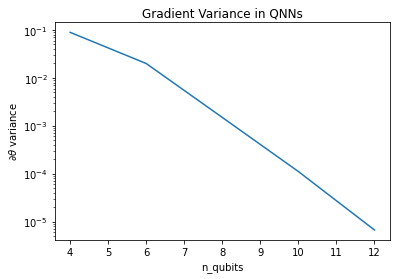

In [7]:
n_qubits = [2 * i for i in range(2, 7)]
depth = 30
n_circuits = 100
hamiltonian = PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)])
theta_vars = []

for n in n_qubits:
    grads = []
    for _ in range(n_circuits):
        # Generate the random circuits and observable for the given n.
        qc = generate_random_qnn(n, Parameter('theta'), depth)
        params = np.random.uniform(0, np.pi, qc.num_parameters)
        grads.append(calc_gradient(qc, hamiltonian, params))
    theta_vars.append(np.var(grads))

plt.semilogy(n_qubits, theta_vars)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

## reference

- https://www.tensorflow.org/quantum/tutorials/barren_plateaus
- https://learn.qiskit.org/course/machine-learning/training-quantum-circuits#training-48-4
- https://www.nature.com/articles/s41467-018-07090-4.pdf

In [6]:
import qiskit.tools.jupyter
%qiskit_version_table